### Controle avançado
Nome: Lucas Correa de Assis

Indentificação do processo de "Ballbeam"

1. O primeiro passo é carregar os dados disponibilizados em [data source](https://ftp.esat.kuleuven.be/pub/SISTA/data/mechanical/ballbeam.dat.gz)

In [16]:
from ballbeam import Ballbeam

dataframe = Ballbeam.loadDataFrame()

dataframe.head()

,input,output
0,-0.001963,-0.004885
1,-0.001963,-0.004641
2,-0.001963,-0.003786
3,-0.001963,-0.004030
4,-0.001963,-0.003908


Como podemos ver temos dados de `input` e `output`

Com o auxilio do material disponibilizado pelo professor Leandro Coelho, implementou-se abstrações para auxilio do estudo a seguir.

In [17]:
from fi import Fi
from theta import Theta
from one_step_forecast import OneStepForecast
from mse import MSE

Nesta seção explorou-se os comportamentos com diferentes quantidade de polos e zeros, utilizando o modelo de previsão de 1 passo a frente.

In [18]:
def add_theta_results(results: dict[str, list], theta: list):
    for i, (key, value) in enumerate(results.items()):
        try:
            value.append(theta[i])
        except:
            value.append('-')

        results[key] = value

In [19]:
import pandas as pd
import numpy as np

results_input = { 'b0': [], 'b1': [], 'b2': [] }
results_output = { 'a1': [], 'a2': [], 'a3': [] }
results_mse = { 'mse': [] }

for poles in range(1,4):
    for zeros in range(1, 4):
        scoped_order = poles if poles > zeros else zeros

        scoped_fi = Fi(dataframe['input'], dataframe['output'], scoped_order)
        # Fazer o processo iterativo para determinação da matriz de valor
        for index, row in dataframe.iterrows():
            scoped_fi.append(index)
    
        scoped_theta = Theta(scoped_fi, dataframe['output'])

        for i in range(len(scoped_theta.get())):
            if poles == zeros:
                continue

            if poles > zeros:
                if i >= zeros and i < scoped_order:
                    scoped_theta.set(i, 0)
                continue

            if i > scoped_order+poles-1:
                scoped_theta.set(i, 0)

        scoped_one_step_forecast = OneStepForecast(dataframe['input'], dataframe['output'], scoped_theta, scoped_order)
        # Fazer o processo iterativo para determinação das previsões
        for index in range(len(dataframe['input'])):
            scoped_one_step_forecast.append(index)

        # record results
        results_mse['mse'].append(MSE(dataframe['output'], scoped_one_step_forecast.get()).get())
        splitted_theta = np.array_split(scoped_theta.get(), 2)
        add_theta_results(results_output, splitted_theta[0])
        add_theta_results(results_input, splitted_theta[1])

results_input.update(results_output)
results_input.update(results_mse)
df = pd.DataFrame(data=results_input)

df

,b0,b1,b2,a1,a2,a3,mse
0,-0.069393,-,-,-0.992341,-,-,0.000045
1,-0.640426,0.0,-,-1.715775,0.716218,-,0.001960
2,-0.184454,0.0,0.0,-1.316732,-0.232204,0.548272,0.000157
3,-0.640426,0.668216,-,-1.715775,0.0,-,0.002707
4,-0.640426,0.668216,-,-1.715775,0.716218,-,0.000020
5,-0.184454,0.073234,0.0,-1.316732,-0.232204,0.548272,0.000057
6,-0.184454,0.073234,0.1793,-1.316732,0.0,0.0,0.000747
7,-0.184454,0.073234,0.1793,-1.316732,-0.232204,0.0,0.001875
8,-0.184454,0.073234,0.1793,-1.316732,-0.232204,0.548272,0.000033


Neste caso observa-se que o melhor resultado é o modelo número `3`, com 2 polos e 2 zeros, obtendo um `MSE` igual a 0.000020.

A partir deste ponto realizou-se uma análise detalhada desse modelo:


2. Carregar vetor de medidas $\phi$

In [20]:
fi = Fi(dataframe['input'], dataframe['output'], order=2)

# Fazer o processo iterativo para determinação da matriz de valor
for index, row in dataframe.iterrows():
    fi.append(index)

fi.get()

array([[ 0.0048852 ,  0.0048852 ,  0.        ,  0.        ],
       [ 0.0048852 ,  0.0048852 ,  0.        ,  0.        ],
       [ 0.00464094,  0.0048852 , -0.0019635 , -0.0019635 ],
       ...,
       [ 0.02625794,  0.03236444, -0.01227186, -0.00932661],
       [ 0.01734245,  0.02625794, -0.01472623, -0.01227186],
       [ 0.01294577,  0.01734245, -0.01668972, -0.01472623]])

3. Estimar vetor de parâmetros $\hat{\theta}$

In [21]:
theta = Theta(fi, dataframe['output'])

print(f'Número de parâmetros estimados (na + nb): {theta.get().size}\n')

theta.get()

Número de parâmetros estimados (na + nb): 4



array([-1.71577454,  0.7162176 , -0.64042573,  0.66821623])

4. Modelo de previsão 1 Passo a frente

In [22]:
one_step_forecast = OneStepForecast(dataframe['input'], dataframe['output'], theta, order=2)

# Fazer o processo iterativo para determinação das previsões
for index in range(len(dataframe['input'])):
    one_step_forecast.append(index)

one_step_forecast.get()[:5]

array([-0.0048852 , -0.00464094, -0.00475613, -0.00384853, -0.00415223])

5. Visualização da previsão

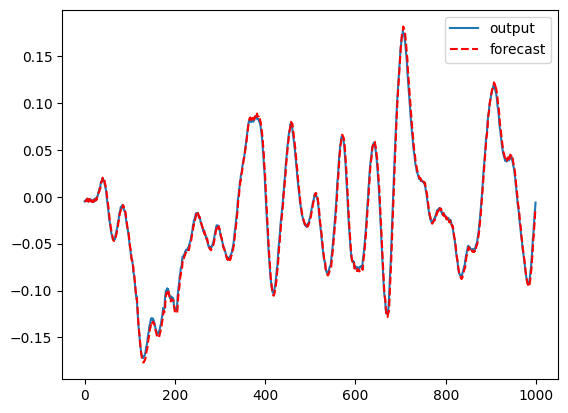

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([i for i in range(len(dataframe['output']))], dataframe['output'])
ax.plot([i for i in range(len(dataframe['output']))], one_step_forecast.get(), 'r--')
plt.legend(['output', 'forecast'])
plt.show()

6. Análise de desempenho com MSE (Mean Squared Error)

In [24]:
mse = MSE(dataframe['output'], one_step_forecast.get())

print(f'Desempenho do modelo {mse.get():.6f}')

Desempenho do modelo 0.000020


7. Modelo de privisão `n` passos a frente

In [25]:
from n_step_forecast import NStepForecast

n_step_forecast = NStepForecast(dataframe['input'], dataframe['output'], theta=theta, order=2)

# Fazer o processo iterativo para determinação das previsões
for index in range(len(dataframe['input'])):
    n_step_forecast.append(index)

n_step_forecast.get()[:5]

array([-0.0048852 , -0.00464094, -0.00451851, -0.00448338, -0.0045108 ])

8. Visualização da previsão

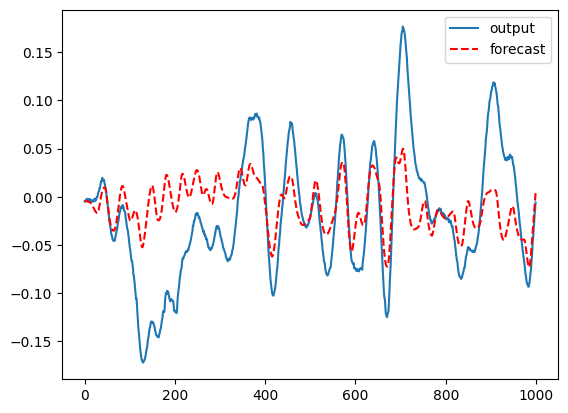

In [26]:
fig, ax = plt.subplots()
ax.plot(dataframe['output'])
ax.plot(n_step_forecast.get(), 'r--')
plt.legend(['output', 'forecast'])
plt.show()

Logo, conclui-se que o modelo com previsão de um passo a frente é mais adequado para esta aplicação.

9. Análise de desempenho com MSE (Mean Squared Error)

In [27]:
mse = MSE(dataframe['output'], n_step_forecast.get())

print(f'Desempenho do modelo {mse.get():.6f}')

Desempenho do modelo 0.003432


In [29]:
# Anderson-Darling Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson

erro = dataframe['output'] - one_step_forecast.get()

result = anderson(erro)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.800
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.653, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.914, data looks normal (fail to reject H0)
1.000: 1.088, data looks normal (fail to reject H0)
